In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, FloatText, Layout, Output, Checkbox
from IPython.display import display, clear_output
from matplotlib import ticker # Import ticker module
from matplotlib.patches import Circle # Import Circle for drawing the workspace

# Robot Specifications (from provided files)
L1 = 0.15  # Length of the first movable link (Link 2 in README)
L2 = 0.15  # Length of the second movable link (Link 3 in README)
L3 = 0.10  # Length of the third movable link (Link 4 in README)
Z_OFFSET = 0.27  # Z-offset from the base to the first joint (Link 1 in README)

# Joint limits in radians (these apply to the "upright is zero, positive clockwise" angles)
THETA_LIMIT_MIN = -np.pi
THETA_LIMIT_MAX = np.pi

# Inverse Kinematics Function (modified for "upright is zero, positive clockwise" output)
def inverse_kinematics(x, z, l1, l2, l3, z_offset):
    """
    Inverse kinematics for a 3DOF planar robot arm in X-Z plane.
    Output angles theta1, theta2, theta3 are in "vertically upright is zero, positive clockwise" convention.

    Parameters:
    x, z       : float - End-effector target position in global frame
    l1, l2, l3 : float - Lengths of the links
    z_offset   : float - Z-offset from base to first joint

    Returns:
    theta1, theta2, theta3 : Joint angles (in radians, "upright is zero, positive clockwise" convention)
    """
    try:
        # Adjust z coordinate by subtracting the z_offset to work in the arm's base frame
        z_adjusted = z - z_offset

        # Calculate absolute end-effector angle (phi) in standard Cartesian convention (0 along +X, positive CCW)
        phi_standard_abs = np.arctan2(z_adjusted, x)

        # Step 1: Compute wrist position (intermediate point between L2 and L3)
        # Using phi_standard_abs for the end-effector's orientation
        x_wrist = x - l3 * np.cos(phi_standard_abs)
        z_wrist = z_adjusted - l3 * np.sin(phi_standard_abs)

        # Step 2: Compute theta2 (relative angle between Link 1 and Link 2)
        # Calculated in standard CCW positive.
        D = (x_wrist**2 + z_wrist**2 - l1**2 - l2**2) / (2 * l1 * l2)
        if np.abs(D) > 1:
            raise ValueError(f"Target ({x:.3f}, {z:.3f}) is out of reach.")
        
        # Taking the "elbow up" solution (positive arccos)
        theta2_standard_relative = np.arccos(D) 

        # Step 3: Compute theta1 (absolute angle of Link 1 from +X axis, standard CCW)
        k1 = l1 + l2 * np.cos(theta2_standard_relative)
        k2 = l2 * np.sin(theta2_standard_relative)
        theta1_standard_abs = np.arctan2(z_wrist, x_wrist) - np.arctan2(k2, k1)

        # Step 4: Compute theta3 (relative angle between Link 2 and Link 3, standard CCW)
        # This is derived from the absolute end-effector angle and the sum of previous standard absolute angles
        theta3_standard_relative = phi_standard_abs - (theta1_standard_abs + theta2_standard_relative)

        # --- Convert calculated standard angles to user's "upright is zero, positive clockwise" convention ---
        # For theta1 (angle relative to global frame):
        # 1. Shift reference from +X to +Z (subtract pi/2)
        # 2. Invert direction (negate) for CW positive
        theta1_user_convention = -(theta1_standard_abs - np.pi/2)

        # For theta2 and theta3 (relative angles):
        # Only invert direction for CW positive, as their relative meaning is preserved.
        theta2_user_convention = -theta2_standard_relative
        theta3_user_convention = -theta3_standard_relative

        # Normalize angles to [-pi, pi] for the user's convention
        angles_output = [theta1_user_convention, theta2_user_convention, theta3_user_convention]
        angles_output = [np.mod(angle + np.pi, 2 * np.pi) - np.pi for angle in angles_output]

        # Check joint limits with the converted angles
        if not all(THETA_LIMIT_MIN <= angle <= THETA_LIMIT_MAX for angle in angles_output):
            raise ValueError("Solution exceeds joint limits.")

        return angles_output[0], angles_output[1], angles_output[2]

    except Exception as e:
        raise ValueError(f"Inverse kinematics failed: {str(e)}")

# Forward Kinematics Function (modified to accept "upright is zero, positive clockwise" angles)
def forward_kinematics(theta1_user, theta2_user, theta3_user, l1, l2, l3, z_offset):
    """
    Computes the (x, z) coordinates of all joints and the end-effector.
    Input angles (theta1, theta2, theta3) are assumed to be in the "vertically upright is zero, positive clockwise" convention.
    """
    joint_base = (0, z_offset)

    # Convert user's "upright is zero, positive clockwise" angles to standard Cartesian (0 along +X, positive CCW)
    # Absolute angle of Link 1 from +X axis: (pi/2 for upright) - (theta1_user for clockwise)
    theta1_cartesian_abs = np.pi/2 - theta1_user
    
    # Absolute angle of Link 2 from +X axis: abs angle of Link 1 - relative theta2 (negated for CCW)
    theta2_cartesian_abs = theta1_cartesian_abs - theta2_user
    
    # Absolute angle of Link 3 from +X axis: abs angle of Link 2 - relative theta3 (negated for CCW)
    theta3_cartesian_abs = theta2_cartesian_abs - theta3_user

    # Position of Joint 2 (tip of Link 1/Moveable Link 1)
    joint2_x = joint_base[0] + l1 * np.cos(theta1_cartesian_abs)
    joint2_z = joint_base[1] + l1 * np.sin(theta1_cartesian_abs)
    joint2 = (joint2_x, joint2_z)

    # Position of Joint 3 (tip of Link 2/Moveable Link 2)
    joint3_x = joint2[0] + l2 * np.cos(theta2_cartesian_abs)
    joint3_z = joint2[1] + l2 * np.sin(theta2_cartesian_abs)
    joint3 = (joint3_x, joint3_z)

    # Position of End-Effector (tip of Link 3/Moveable Link 3)
    end_effector_x = joint3[0] + l3 * np.cos(theta3_cartesian_abs)
    end_effector_z = joint3[1] + l3 * np.sin(theta3_cartesian_abs)
    end_effector = (end_effector_x, end_effector_z)

    return joint_base, joint2, joint3, end_effector

# Plotting function (updated for denser axis numbering and workspace circles)
def update_robot_plot(theta1, theta2, theta3, target_x=None, target_z=None, ik_mode_active=False):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle=':', linewidth=0.5) # Show grid for both major and minor ticks
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title('3-DOF Planar Robot Arm Visualization')

    # Set plot limits dynamically
    max_total_reach = Z_OFFSET + L1 + L2 + L3
    ax.set_xlim([-max_total_reach, max_total_reach])
    ax.set_ylim([-0.1, max_total_reach + 0.1])

    # --- Make axis numbering more dense ---
    # Set major ticks every 0.1m
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    # Set minor ticks every 0.05m
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

    # --- Draw allowable workspace circles ---
    # Center of the workspace circles is the base of the moving arm
    workspace_center_x = 0
    workspace_center_z = Z_OFFSET

    # Define workspace radii
    R_max = L1 + L2 + L3  # Maximum reach: when all links are extended
    R_min = L3 # Minimum reach for this specific link configuration (L1=L2=0.15, L3=0.10)
                # When L1 and L2 fold back on each other, their combined length is 0, leaving L3.

    # Draw outer workspace circle
    outer_circle = Circle((workspace_center_x, workspace_center_z), R_max,
                          color='gray', fill=False, linestyle='--', linewidth=1.5, alpha=0.5)
    ax.add_patch(outer_circle)

    # Draw inner workspace circle (if R_min > 0)
    if R_min > 0:
        inner_circle = Circle((workspace_center_x, workspace_center_z), R_min,
                              color='darkgray', fill=False, linestyle='--', linewidth=1.5, alpha=0.5)
        ax.add_patch(inner_circle)
    
    # Add a legend for the workspace circles (optional, can be commented out if too cluttered)
    ax.plot([], [], color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='Max Workspace')
    if R_min > 0:
        ax.plot([], [], color='darkgray', linestyle='--', linewidth=1.5, alpha=0.5, label='Min Workspace')

    # Draw base (Link 0)
    ax.plot([-0.05, 0.05], [0, 0], 'k-', linewidth=3, label='Link 0 (Fixed Base)')
    ax.plot(0, 0, 'ks', markersize=10, label='Base Joint')

    # Draw fixed vertical link (Z_OFFSET)
    ax.plot([0, 0], [0, Z_OFFSET], 'k--', linewidth=1, label='Fixed Link (Z-offset)')

    # Get joint positions from Forward Kinematics
    # Pass the user-convention angles directly to FK, as it handles the internal conversion.
    joint_base, joint2, joint3, end_effector = forward_kinematics(theta1, theta2, theta3, L1, L2, L3, Z_OFFSET)

    # Plot robot links and joints
    ax.plot([joint_base[0], joint2[0]], [joint_base[1], joint2[1]], 'b-', linewidth=4, label='Link 1 (Moveable)')
    ax.plot([joint2[0], joint3[0]], [joint2[1], joint3[1]], 'g-', linewidth=4, label='Link 2 (Moveable)')
    ax.plot([joint3[0], end_effector[0]], [joint3[1], end_effector[1]], 'r-', linewidth=4, label='Link 3 (Moveable)')

    # Plot joints as circles
    ax.plot(joint_base[0], joint_base[1], 'o', color='black', markersize=8) # Label already given above
    ax.plot(joint2[0], joint2[1], 'o', color='red', markersize=8)
    ax.plot(joint3[0], joint3[1], 'o', color='red', markersize=8)
    ax.plot(end_effector[0], end_effector[1], 'o', color='green', markersize=8, label='End-Effector')

    # Plot target if IK mode is active
    if ik_mode_active and target_x is not None and target_z is not None:
        ax.plot(target_x, target_z, 'kx', markersize=12, linewidth=2, label='Target (IK)')

    ax.legend(loc='upper right', fontsize='small') # Display legend
    plt.show()

# --- Declare widgets globally so their properties can be accessed ---
# Initial value of 0.0 for sliders will now correctly mean "vertically upright"
theta1_widget = FloatSlider(min=THETA_LIMIT_MIN, max=THETA_LIMIT_MAX, step=0.01, value=0.0, description='θ1 (rad):', layout=Layout(width='auto'))
theta2_widget = FloatSlider(min=THETA_LIMIT_MIN, max=THETA_LIMIT_MAX, step=0.01, value=0.0, description='θ2 (rad):', layout=Layout(width='auto'))
theta3_widget = FloatSlider(min=THETA_LIMIT_MIN, max=THETA_LIMIT_MAX, step=0.01, value=0.0, description='θ3 (rad):', layout=Layout(width='auto'))
target_x_widget = FloatText(value=0.2, description='Target X (m):', layout=Layout(width='200px'))
target_z_widget = FloatText(value=0.4, description='Target Z (m):', layout=Layout(width='200px'))
ik_mode_widget = Checkbox(value=False, description='Enable IK Mode', layout=Layout(width='auto'))

# Widget to display IK results and status
ik_status_output = Output()

@interact(
    ik_mode=ik_mode_widget,
    theta1_val=theta1_widget,
    theta2_val=theta2_widget,
    theta3_val=theta3_widget,
    target_x_val=target_x_widget,
    target_z_val=target_z_widget
)
def interactive_robot(ik_mode, theta1_val, theta2_val, theta3_val, target_x_val, target_z_val):
    # Retrieve current values from the widgets
    current_theta1 = theta1_val
    current_theta2 = theta2_val
    current_theta3 = theta3_val
    target_x = target_x_val
    target_z = target_z_val
    
    # Enable/disable input widgets based on IK mode
    theta1_widget.disabled = ik_mode
    theta2_widget.disabled = ik_mode
    theta3_widget.disabled = ik_mode
    target_x_widget.disabled = not ik_mode
    target_z_widget.disabled = not ik_mode

    with ik_status_output:
        clear_output(wait=True)
        if ik_mode:
            print("IK Mode: ACTIVE (Enter Target X, Z)")
            try:
                # Call IK, which now returns angles in your desired convention
                ik_theta1, ik_theta2, ik_theta3 = inverse_kinematics(target_x, target_z, L1, L2, L3, Z_OFFSET)
                current_theta1, current_theta2, current_theta3 = ik_theta1, ik_theta2, ik_theta3
                print(f"Target Position: X={target_x:.3f}m, Z={target_z:.3f}m")
                print(f"IK Calculated Angles: θ1={np.degrees(ik_theta1):.2f}°, θ2={np.degrees(ik_theta2):.2f}°, θ3={np.degrees(ik_theta3):.2f}°")
                
                # Update sliders to reflect IK calculated angles in the user's convention
                theta1_widget.value = ik_theta1
                theta2_widget.value = ik_theta2
                theta3_widget.value = ik_theta3

            except ValueError as e:
                print(f"IK Error: {e}")
        else:
            print("Manual Control Mode: ACTIVE (Use Sliders)")
            print(f"Current Joint Angles: θ1={np.degrees(theta1_widget.value):.2f}°, θ2={np.degrees(theta2_widget.value):.2f}°, θ3={np.degrees(theta3_widget.value):.2f}°")
    
    # Always plot the robot based on the current angles (either from sliders or successful IK)
    update_robot_plot(current_theta1, current_theta2, current_theta3, target_x=target_x, target_z=target_z, ik_mode_active=ik_mode)

# Display the IK status/output widget
display(ik_status_output)

interactive(children=(Checkbox(value=False, description='Enable IK Mode', layout=Layout(width='auto')), FloatS…

Output()

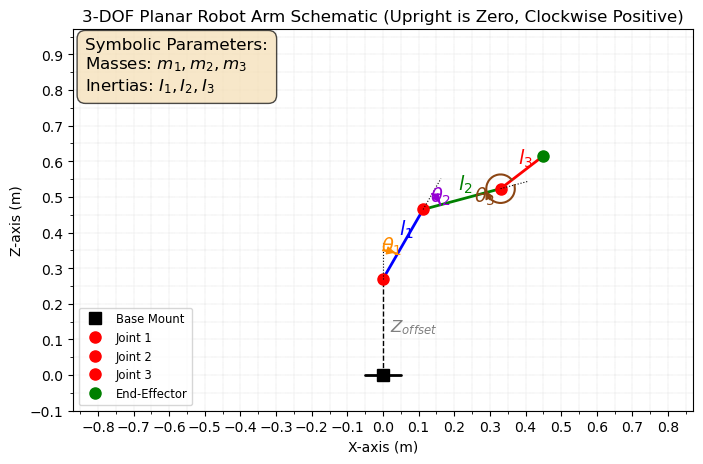

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc # For drawing angles
from sympy import symbols # Just for conceptual consistency with dynamics symbols
from matplotlib import ticker # Import ticker module

# Define symbolic parameters for the diagram
l1_sym, l2_sym, l3_sym = symbols('l_1 l_2 l_3')
theta1_sym, theta2_sym, theta3_sym = symbols('theta_1 theta_2 theta_3')
Z_OFFSET_sym = symbols('Z_{offset}')
m1_sym, m2_sym, m3_sym = symbols('m_1 m_2 m_3') # Masses
I1_sym, I2_sym, I3_sym = symbols('I_1 I_2 I_3') # Inertias

# Use numerical values for plotting the static diagram (illustrative pose)
# These are just for drawing, not symbolic computation here.
L1_val = 0.15 * 1.5
L2_val = 0.15 * 1.5
L3_val = 0.10 * 1.5
Z_OFFSET_val = 0.27 # From your robot specifications

# Illustrative angles in your convention (0 upright, positive clockwise)
# Let's choose non-zero angles to clearly show direction and all links
THETA1_val = np.pi / 6    # 30 degrees clockwise from upright
THETA2_val = np.pi / 4    # 45 degrees clockwise relative to Link 1
THETA3_val = -np.pi / 8   # -22.5 degrees (counter-clockwise) relative to Link 2

# --- Calculations for plotting based on "0 upright, positive clockwise" convention ---
# Convert user's angles to standard Cartesian (0 along +X, positive CCW) for np.cos/np.sin
# Absolute angle of Link 1 from +X axis: (pi/2 for upright) - (theta1_user for clockwise)
theta1_cartesian_abs = np.pi/2 - THETA1_val
# Absolute angle of Link 2 from +X axis: abs angle of Link 1 - relative theta2 (negated for CCW)
theta2_cartesian_abs = theta1_cartesian_abs - THETA2_val
# Absolute angle of Link 3 from +X axis: abs angle of Link 2 - relative theta3 (negated for CCW)
theta3_cartesian_abs = theta2_cartesian_abs - THETA3_val

# Joint coordinates
# Base is at (0,0)
base_x, base_z = 0, 0

# Joint 1 (start of movable arm)
joint1_x = 0
joint1_z = Z_OFFSET_val

# Joint 2 (end of Link 1, start of Link 2)
joint2_x = joint1_x + L1_val * np.cos(theta1_cartesian_abs)
joint2_z = joint1_z + L1_val * np.sin(theta1_cartesian_abs)

# Joint 3 (end of Link 2, start of Link 3)
joint3_x = joint2_x + L2_val * np.cos(theta2_cartesian_abs)
joint3_z = joint2_z + L2_val * np.sin(theta2_cartesian_abs)

# End-effector (end of Link 3)
end_effector_x = joint3_x + L3_val * np.cos(theta3_cartesian_abs)
end_effector_z = joint3_z + L3_val * np.sin(theta3_cartesian_abs)

# --- Create the plot ---
fig, ax = plt.subplots(figsize=(8, 8)) # height, width
# Other aspect ratios: 'equal', 'auto', float (e.g., 1.0 for square, 0.5 for wide, etc.)
ax.set_aspect('equal')
# Set plot limits dynamically based on max reach + Z_OFFSET
max_total_reach = Z_OFFSET_val + L1_val + L2_val + L3_val
ax.set_xlim([-max_total_reach, max_total_reach])
ax.set_ylim([-0.1, max_total_reach + 0.1]) # Ensure base is visible and some space above

ax.grid(True, which='both', linestyle=':', linewidth=0.3)
ax.set_xlabel('X-axis (m)')
ax.set_ylabel('Z-axis (m)')
ax.set_title('3-DOF Planar Robot Arm Schematic (Upright is Zero, Clockwise Positive)')

# --- Make axis numbering more dense ---
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))


# --- Draw the links ---
# Fixed base segment (Link 0)
ax.plot([base_x - 0.05, base_x + 0.05], [base_z, base_z], 'k-', linewidth=2, solid_capstyle='round')
ax.plot(base_x, base_z, 'ks', markersize=8, label='Base Mount') # Base joint/mount

# Z-Offset (fixed vertical link)
ax.plot([base_x, joint1_x], [base_z, joint1_z], 'k--', linewidth=1)
ax.text(joint1_x + 0.02, joint1_z / 2, r'$Z_{offset}$', color='gray', fontsize=12, ha='left', va='center')


# Link 1 (movable)
ax.plot([joint1_x, joint2_x], [joint1_z, joint2_z], 'b-', linewidth=2, solid_capstyle='round')
ax.plot(joint1_x, joint1_z, 'ro', markersize=8, label='Joint 1') # Joint 1
# Link length annotation
link1_mid_x = (joint1_x + joint2_x) / 2
link1_mid_z = (joint1_z + joint2_z) / 2
ax.text(link1_mid_x + 0.01, link1_mid_z + 0.01, r'$l_1$', color='blue', fontsize=14, ha='center', va='bottom')

# Link 2 (movable)
ax.plot([joint2_x, joint3_x], [joint2_z, joint3_z], 'g-', linewidth=2, solid_capstyle='round')
ax.plot(joint2_x, joint2_z, 'ro', markersize=8, label='Joint 2') # Joint 2
# Link length annotation
link2_mid_x = (joint2_x + joint3_x) / 2
link2_mid_z = (joint2_z + joint3_z) / 2
ax.text(link2_mid_x + 0.01, link2_mid_z + 0.01, r'$l_2$', color='green', fontsize=14, ha='center', va='bottom')

# Link 3 (movable)
ax.plot([joint3_x, end_effector_x], [joint3_z, end_effector_z], 'r-', linewidth=2, solid_capstyle='round')
ax.plot(joint3_x, joint3_z, 'ro', markersize=8, label='Joint 3') # Joint 3
# Link length annotation
link3_mid_x = (joint3_x + end_effector_x) / 2
link3_mid_z = (joint3_z + end_effector_z) / 2
ax.text(link3_mid_x + 0.01, link3_mid_z + 0.01, r'$l_3$', color='red', fontsize=14, ha='center', va='bottom')

ax.plot(end_effector_x, end_effector_z, 'go', markersize=8, label='End-Effector') # End-effector


# --- Draw angle notations and directions ---
# Helper function to draw clockwise arrows on arcs
def draw_clockwise_arrow(ax, center_x, center_z, radius, start_angle_deg, end_angle_deg, color, text, text_offset_factor=1.2):
    # Ensure start_angle_deg > end_angle_deg for clockwise sweep
    # If end_angle_deg is greater than start_angle_deg (e.g., sweeping past 0/360), adjust start_angle_deg
    if end_angle_deg > start_angle_deg:
        end_angle_deg -= 360 # Make it a negative sweep to represent clockwise correctly in Arc

    arc = Arc((center_x, center_z), radius*2, radius*2,
              theta1=end_angle_deg, theta2=start_angle_deg, color=color, linewidth=1.5,
              capstyle='round', zorder=2)
    ax.add_patch(arc)

    # Calculate midpoint angle for arrow placement (in radians, standard Cartesian CCW from +X)
    # Average of the two angles for the arc, then convert to radians.
    # Adjust for potential negative end_angle_deg from above.
    mid_angle_deg = (start_angle_deg + end_angle_deg) / 2
    if mid_angle_deg < 0: # If mid_angle_deg became negative, normalize to 0-360 for correct trig
        mid_angle_deg += 360
    mid_angle_rad = np.radians(mid_angle_deg)

    # Calculate arrow position on the arc
    arrow_x = center_x + radius * np.cos(mid_angle_rad)
    arrow_z = center_z + radius * np.sin(mid_angle_rad)

    # Calculate arrow direction for clockwise tangent
    # Tangent vector for CW positive is (sin(angle_rad), -cos(angle_rad))
    # We want the arrow to point *along* the arc in the clockwise direction.
    # The vector from the center to the arrow point is (cos(mid_angle_rad), sin(mid_angle_rad)).
    # The tangent vector pointing clockwise is (sin(mid_angle_rad), -cos(mid_angle_rad)).
    # For annotate, xy is the tip, xytext is the tail.
    # So, tail = arrow_point - small_vector_in_opposite_direction
    # Tip = arrow_point + small_vector_in_direction
    arrow_len_factor = 0.01 # Controls arrow size
    dx_arrow_vec = arrow_len_factor * np.sin(mid_angle_rad)
    dz_arrow_vec = -arrow_len_factor * np.cos(mid_angle_rad)

    ax.annotate('', xy=(arrow_x + dx_arrow_vec, arrow_z + dz_arrow_vec),
                xytext=(arrow_x - dx_arrow_vec, arrow_z - dz_arrow_vec),
                arrowprops=dict(facecolor=color, edgecolor=color, shrink=0.0, width=0.5, headwidth=5, headlength=5))

    # Text placement
    text_x = center_x + radius * text_offset_factor * np.cos(mid_angle_rad)
    text_z = center_z + radius * text_offset_factor * np.sin(mid_angle_rad)
    ax.text(text_x, text_z, text, color=color, fontsize=14, ha='center', va='center')


# Theta1 (angle of Link 1 from vertical)
# Draw vertical line for theta1 reference
ax.plot([joint1_x, joint1_x], [joint1_z, joint1_z + 0.1], 'k:', linewidth=0.8)
# Arc and arrow for theta1
draw_clockwise_arrow(ax, joint1_x, joint1_z, 0.08, 90, 90 - np.degrees(THETA1_val), 'darkorange', r'$\theta_1$')


# Theta2 (angle of Link 2 relative to Link 1)
# Draw reference line for theta2 (extension of Link 1)
ref_line_len = 0.1
ref_line_x_start = joint2_x
ref_line_z_start = joint2_z
ref_line_x_end = joint2_x + ref_line_len * np.cos(theta1_cartesian_abs)
ref_line_z_end = joint2_z + ref_line_len * np.sin(theta1_cartesian_abs)
ax.plot([ref_line_x_start, ref_line_x_end], [ref_line_z_start, ref_line_z_end], 'k:', linewidth=0.8)
# Arc and arrow for theta2
draw_clockwise_arrow(ax, joint2_x, joint2_z, 0.05, np.degrees(theta1_cartesian_abs), np.degrees(theta1_cartesian_abs - THETA2_val), 'darkviolet', r'$\theta_2$')


# Theta3 (angle of Link 3 relative to Link 2)
# Draw reference line for theta3 (extension of Link 2)
ref_line_len3 = 0.08
ref_line_x3_start = joint3_x
ref_line_z3_start = joint3_z
ref_line_x3_end = joint3_x + ref_line_len3 * np.cos(theta2_cartesian_abs)
ref_line_z3_end = joint3_z + ref_line_len3 * np.sin(theta2_cartesian_abs)
ax.plot([ref_line_x3_start, ref_line_x3_end], [ref_line_z3_start, ref_line_z3_end], 'k:', linewidth=0.8)
# Arc and arrow for theta3
draw_clockwise_arrow(ax, joint3_x, joint3_z, 0.04, np.degrees(theta2_cartesian_abs), np.degrees(theta2_cartesian_abs - THETA3_val), 'saddlebrown', r'$\theta_3$')


# Add a text box for symbolic parameters (masses, inertias)
text_params = (
    r'Symbolic Parameters:' '\n'
    r'Masses: $m_1, m_2, m_3$' '\n'
    r'Inertias: $I_1, I_2, I_3$'
)
ax.text(0.02, 0.98, text_params, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))


ax.legend(loc='lower left', fontsize='small')
plt.show()

In [12]:
from sympy import symbols, latex, cos, sin, Matrix, pi # Import pi from sympy
from sympy.physics.mechanics import dynamicsymbols
from IPython.display import display, Math

# Define symbolic parameters
theta1, theta2, theta3 = dynamicsymbols('theta1 theta2 theta3')
l1, l2, l3 = symbols('l1 l2 l3')
Z_OFFSET_sym = symbols('Z_{offset}')

# Convert user's angles (0 upright, positive clockwise) to standard Cartesian (0 +X, positive CCW)
# Use sympy.pi for symbolic representation
# Absolute angle of Link 1 from +X axis: (pi/2 for upright) - (theta1_user for clockwise)
theta1_cartesian_abs = pi/2 - theta1
# Absolute angle of Link 2 from +X axis: abs angle of Link 1 - relative theta2 (negated for CCW)
theta2_cartesian_abs = theta1_cartesian_abs - theta2
# Absolute angle of Link 3 from +X axis: abs angle of Link 2 - relative theta3 (negated for CCW)
theta3_cartesian_abs = theta2_cartesian_abs - theta3

# --- Joint Positions ---

# Joint 1 (Base of the movable arm, after Z_offset)
# This is the pivot point for Link 1
joint1_pos = Matrix([0, Z_OFFSET_sym])

# Joint 2 (End of Link 1, Start of Link 2)
# Relative to Joint 1
joint2_x = joint1_pos[0] + l1 * cos(theta1_cartesian_abs)
joint2_z = joint1_pos[1] + l1 * sin(theta1_cartesian_abs)
joint2_pos = Matrix([joint2_x, joint2_z])

# Joint 3 (End of Link 2, Start of Link 3)
# Relative to Joint 2
joint3_x = joint2_pos[0] + l2 * cos(theta2_cartesian_abs)
joint3_z = joint2_pos[1] + l2 * sin(theta2_cartesian_abs)
joint3_pos = Matrix([joint3_x, joint3_z])

# End-Effector Position (Tip of Link 3)
# Relative to Joint 3
end_effector_x = joint3_pos[0] + l3 * cos(theta3_cartesian_abs)
end_effector_z = joint3_pos[1] + l3 * sin(theta3_cartesian_abs)
end_effector_pos = Matrix([end_effector_x, end_effector_z])

# --- Display the positions ---
display(Math(r"\textbf{Symbolic Joint Positions}"))
display(Math(r"\text{Joint 1 (Base of movable arm): } \vec{P}_1 = " + latex(joint1_pos)))
display(Math(r"\text{Joint 2 (End of Link 1): } \vec{P}_2 = " + latex(joint2_pos)))
display(Math(r"\text{Joint 3 (End of Link 2): } \vec{P}_3 = " + latex(joint3_pos)))
display(Math(r"\text{End-Effector (Tip of Link 3): } \vec{P}_{EE} = " + latex(end_effector_pos)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
v1, v2, v3 , v4 , v_ee , t = symbols('v1 v2 v3 v4 v_ee t')
v1 = joint1_pos.diff(t) # Velocity of Joint 1 (base of movable arm)
v2 = joint2_pos.diff(t) # Velocity of Joint 2
v3 = joint3_pos.diff(t) # Velocity of Joint 3
v_ee = end_effector_pos.diff(t) # Velocity of End-Effector

# --- Display the velocities ---
display(Math(r"\textbf{Symbolic Joint Velocities}"))
display(Math(r"\text{Velocity of Joint 1: } \vec{v}_1 = " + latex(v1)))
display(Math(r"\text{Velocity of Joint 2: } \vec{v}_2 = " + latex(v2)))
display(Math(r"\text{Velocity of Joint 3: } \vec{v}_3 = " + latex(v3)))
display(Math(r"\text{Velocity of End-Effector: } \vec{v}_{EE} = " + latex(v_ee)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>